# Exploratory data analysis of the Strathcona County housing price

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from pandas_profiling import ProfileReport

In [3]:
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data and filter for residential

In [5]:
df = pd.read_csv("../data/2018_Property_Tax_Assessment.csv", skiprows = 1)
df = df.query("ASSESSCLAS == 'Residential'")
df.head()

,the_geom,TAX_YEAR,ROLL_NUM,ADDRESS,YEAR_BUILT,ASSESSCLAS,BLDG_DESC,BLDG_METRE,BLDG_FEET,GARAGE,FIREPLACE,BASEMENT,BSMTDEVL,ASSESSMENT,LATITUDE,LONGITUDE
1,POINT (-113.26140189927364 53.523991245712466),2018,7251135003,557 FORREST DR,2003.0,Residential,1 Storey & Basement,143,1538,Y,Y,Y,Y,516000,53.523805,-113.261276
3,POINT (-113.27484287251478 53.52589053315396),2018,7207002002,39 GREENRIDGE DR,1985.0,Residential,2 Storey & Basement,176,1899,Y,Y,Y,Y,434000,53.526015,-113.275070
4,POINT (-113.28827567138487 53.5272820077841),2018,7065021003,41 PEACOCK DR,1969.0,Residential,1 Storey & Basement,104,1119,Y,Y,Y,Y,337000,53.527206,-113.288567
5,POINT (-113.31132040699521 53.526290475490406),2018,7037018004,2001 FAIRVIEW CRT,1965.0,Residential,Split Entry,115,1235,Y,N,Y,Y,411000,53.526195,-113.311699
6,POINT (-113.02630711613794 53.600541862034355),2018,3128503004,53408 RNG RD 213,1979.0,Residential,1 Storey & Basement,182,1963,Y,Y,Y,Y,660000,53.600583,-113.027326


## Summary of the data set

### Property assessment distribution

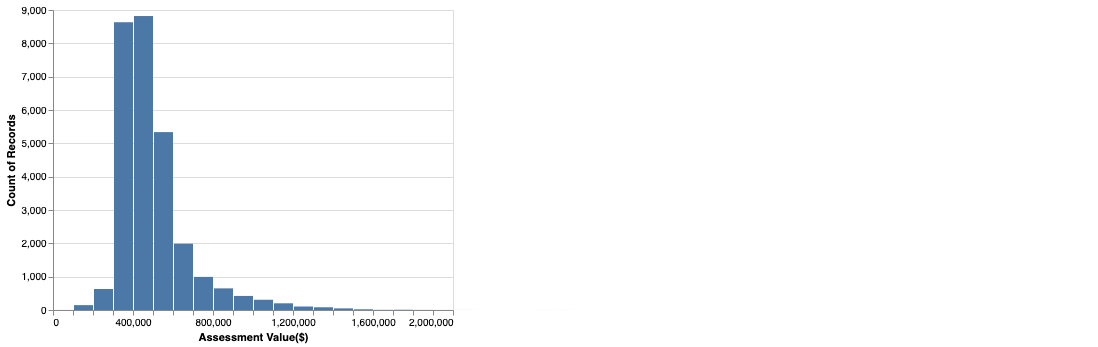

In [17]:
alt.Chart(df).mark_bar().encode(
    alt.X('ASSESSMENT', bin=alt.Bin(maxbins=60), scale=alt.Scale(domain=(0,2000000)), title='Assessment Value($)'),
    alt.Y('count()'),
    tooltip='count()'
)

## Partition the data set into training and test sets

Before processing the data, we split the data such that 90% of observations are in the training and 10% of observations are in the test set.

In [18]:
train_df, test_df = train_test_split(df, test_size = 0.10, random_state=123)
train_df.head()

,the_geom,TAX_YEAR,ROLL_NUM,ADDRESS,YEAR_BUILT,ASSESSCLAS,BLDG_DESC,BLDG_METRE,BLDG_FEET,GARAGE,FIREPLACE,BASEMENT,BSMTDEVL,ASSESSMENT,LATITUDE,LONGITUDE
7699,POINT (-113.27868410154399 53.52422473391141),2018,7204013002,23 NOTTINGHAM RD,1990.0,Residential,2 Storey & Basement,203,2189,Y,Y,Y,Y,505000,53.524152,-113.278945
34102,POINT (-113.28660933668657 53.559666067846145),2018,8181003005,10 ABERDEEN CR,2017.0,Residential,2 Storey & Basement,133,1433,Y,Y,Y,N,356000,53.559605,-113.286851
24119,POINT (-113.223672178728 53.48196513896649),2018,2207103009,265 52152 RNG RD 225,1979.0,Residential,2 Storey & Basement,192,2067,Y,Y,Y,Y,571000,53.482807,-113.224167
4829,POINT (-113.25723973453104 53.542257139037815),2018,8001039000,36 DEWBERRY PL,1989.0,Residential,Split Level & Crawl Space,125,1342,Y,Y,Y,Y,410000,53.542325,-113.257504
12129,POINT (-113.27062226263668 53.53298593959325),2018,7281074103,165 COURTENAY DR,1998.0,Residential,2 Storey & Basement,204,2194,Y,Y,Y,Y,519000,53.532916,-113.270911


In [19]:
train_df.shape

(25605, 16)

In [20]:
X_train = train_df.drop(columns=['ASSESSMENT'])
y_train = train_df['ASSESSMENT']

X_test = test_df.drop(columns=['ASSESSMENT'])
y_test = test_df['ASSESSMENT']

## Exploratory data analysis (EDA) on the training data set

In [21]:
train_df.describe()

,TAX_YEAR,ROLL_NUM,YEAR_BUILT,BLDG_METRE,BLDG_FEET,ASSESSMENT,LATITUDE,LONGITUDE
count,25605.0,2.560500e+04,25597.000000,25605.000000,25605.000000,2.560500e+04,25605.000000,25605.000000
mean,2018.0,6.095382e+09,1988.663398,156.877836,1688.720328,4.961323e+05,53.525498,-113.244651
std,0.0,2.417761e+09,16.522669,58.341542,627.915539,1.927636e+05,0.040672,0.084889
min,2018.0,1.002702e+09,1900.000000,9.000000,100.000000,2.900000e+04,53.366914,-113.344318
25%,2018.0,3.215714e+09,1973.000000,114.000000,1228.000000,3.790000e+05,53.515648,-113.289593
50%,2018.0,7.160092e+09,1991.000000,141.000000,1519.000000,4.500000e+05,53.529335,-113.269052
75%,2018.0,8.007022e+09,2003.000000,188.000000,2024.000000,5.450000e+05,53.547183,-113.250371
max,2018.0,9.503053e+09,2018.000000,954.000000,10270.000000,5.182000e+06,53.858663,-112.846514


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25605 entries, 7699 to 23031
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    25605 non-null  object 
 1   TAX_YEAR    25605 non-null  int64  
 2   ROLL_NUM    25605 non-null  int64  
 3   ADDRESS     25582 non-null  object 
 4   YEAR_BUILT  25597 non-null  float64
 5   ASSESSCLAS  25605 non-null  object 
 6   BLDG_DESC   25597 non-null  object 
 7   BLDG_METRE  25605 non-null  int64  
 8   BLDG_FEET   25605 non-null  int64  
 9   GARAGE      25605 non-null  object 
 10  FIREPLACE   25605 non-null  object 
 11  BASEMENT    25605 non-null  object 
 12  BSMTDEVL    25605 non-null  object 
 13  ASSESSMENT  25605 non-null  int64  
 14  LATITUDE    25605 non-null  float64
 15  LONGITUDE   25605 non-null  float64
dtypes: float64(3), int64(5), object(8)
memory usage: 3.3+ MB


### `pandas_profiler`

In [23]:
from pandas_profiling import ProfileReport

profile = ProfileReport(train_df, title='Pandas Profiling Report', minimal=True)
profile.to_notebook_iframe()

### Examine correlations of relevant features with the target

In [24]:
df_cor = df.drop(columns=['TAX_YEAR', 'ROLL_NUM'])

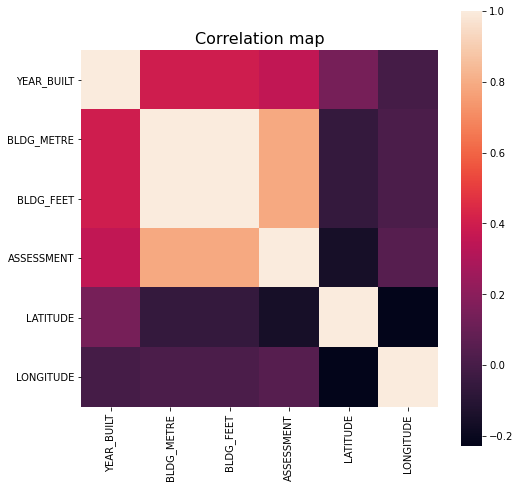

In [25]:
corrmat = df_cor.corr(method='pearson')
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Correlation map", fontsize=16)
plt.show()

### Identify numeric, categorical, binary, and other features

In [26]:
numeric_features=['YEAR_BUILT','BLDG_METRE', 'BLDG_FEET', 'LATITUDE','LONGITUDE']

In [27]:
categorical_features=['ADDRESS']

In [28]:
binary_features=['GARAGE', 'FIREPLACE', 'BASEMENT', 'BASEMENTDVL']

In [29]:
drop_features=['the_geom', 'TAX_YEAR', 'ROLL_NUM', 'ASSESSCLAS', 'BLDF_DESC']

In [30]:
target = 'ASSESSMENT'

### Relationship between building sizes and assessed values

In [31]:
df_bsav = train_df.groupby('BLDG_METRE').mean('ASSESSMENT')
df_bsav = df_bsav.reset_index()

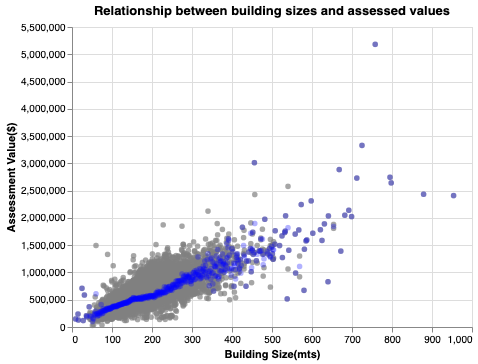

In [32]:
alt.data_transformers.disable_max_rows()
population = alt.Chart(train_df, title = "Relationship between building sizes and assessed values").mark_circle(color='grey').encode(
    alt.X('BLDG_METRE', title = "Building Size(mts)"),
    alt.Y('ASSESSMENT', title = "Assessment Value($)"))

conditional = alt.Chart(df_bsav).mark_circle(opacity=0.3, color='blue').encode(
    alt.X('BLDG_METRE', title = "Building Size(mts)"),
    alt.Y('ASSESSMENT', title = "Assessment Value($)"))

population + conditional

### Box plots and density plots

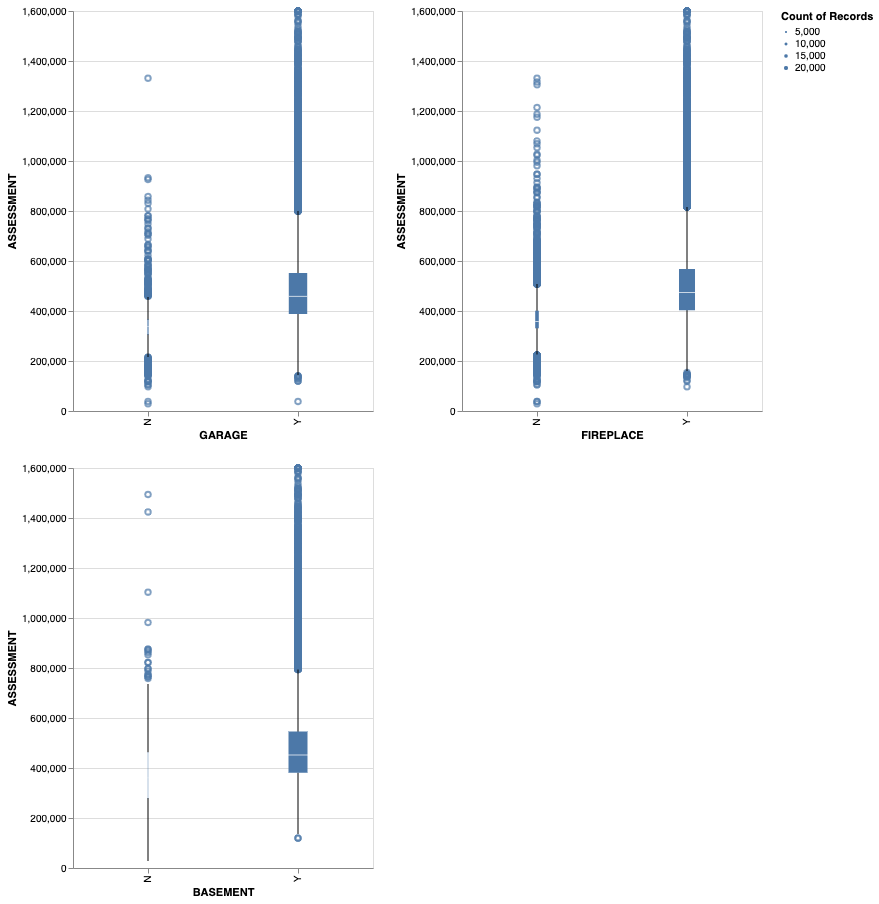

In [83]:
y_range=[0, 1_600_000]
(alt.Chart(train_df).mark_boxplot().encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('ASSESSMENT:Q', scale=alt.Scale(domain=y_range, clamp=True)),
    size='count()')
 .properties(height=400, width=300)
 .repeat(['GARAGE', 'FIREPLACE', 'BASEMENT'], columns=2))

In [74]:
import altair as alt
from vega_datasets import data

garage =(alt.Chart(train_df).transform_density(
    'ASSESSMENT',
    as_=['ASSESSMENT', 'density'],
    extent=[0, 1_600_000],
    groupby=['GARAGE']
).mark_area(orient='horizontal').encode(
    y='ASSESSMENT:Q',
    color='GARAGE:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'GARAGE:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
))

In [75]:
fireplace = (alt.Chart(train_df).transform_density(
    'ASSESSMENT',
    as_=['ASSESSMENT', 'density'],
    extent=[0, 1_600_000],
    groupby=['FIREPLACE']
).mark_area(orient='horizontal').encode(
    y='ASSESSMENT:Q',
    color='FIREPLACE:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'FIREPLACE:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
))

In [76]:
basement = (alt.Chart(train_df).transform_density(
    'ASSESSMENT',
    as_=['ASSESSMENT', 'density'],
    extent=[0, 1_600_000],
    groupby=['BASEMENT']
).mark_area(orient='horizontal').encode(
    y='ASSESSMENT:Q',
    color='BASEMENT:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'BASEMENT:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
))

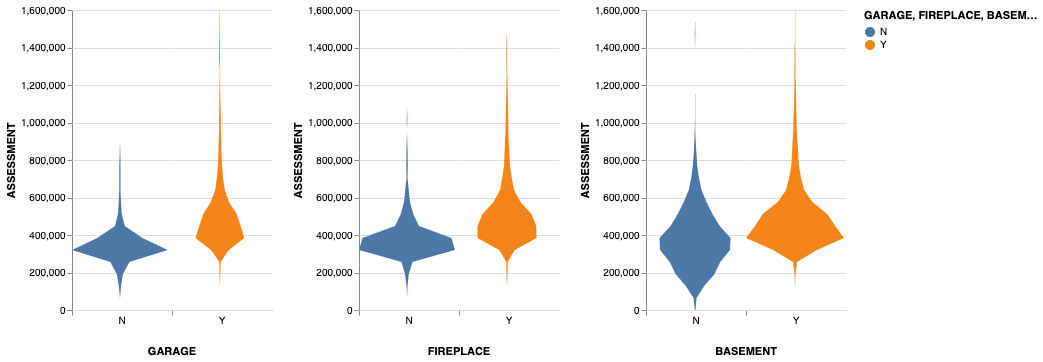

In [77]:
alt.hconcat(garage, fireplace, basement).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

## References

“2018 Property Tax Assessment”. Strathcona County’s Open Data Portal. <https://data.strathcona.ca/Housing-Buildings/2018-Property-Tax-Assessment/6wvk-j7e9>